# Operations on word vectors

通过这次作业，将掌握以下技能：  
1.如何加载训练好了的词向量  
2.使用余弦相似性计算相似度  
3.使用词嵌入来解决“男人与女人相比就像国王与____ 相比”之类的词语类比问题  
4.修改词嵌入以减少性别偏见  

In [1]:
import numpy as np
from w2v_utils import *

Using TensorFlow backend.


加载词向量，这里使用50维的向量表示单词  
* words:词汇表中的单词
* word_to_vec_map:字典类型，单词到GloVe向量的映射

In [3]:
words, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

### 1.1 - 余弦相似度
为了衡量两个词的相似程度，我们需要一种方法来衡量两个词的词嵌入向量之间的相似程度，给定两个向量u和v，余弦相似度定义如下:$$\text{CosineSimilarity(u, v)} = \frac {u . v} {||u||_2 ||v||_2} = cos(\theta) \tag{1}$$  
其中$u.v$ 是两个向量的点积（内积），$||u||_2$ 是u的范数（长度）,$\theta$ 是 $u$和 $v$之间的夹角。$u$与$v$之间的相似度是基于他们之间的角度计算的。他们越相似，那么cos(θ) 的值就越接近于1；如果它们很不相似，那么他们的夹角就越大，cos(θ)的值就越接近于-1。

In [4]:
def cosine_similarity(u, v):
    """
    Cosine similarity reflects the degree of similariy between u and v
        
    Arguments:
        u -- a word vector of shape (n,)          
        v -- a word vector of shape (n,)

    Returns:
        cosine_similarity -- the cosine similarity between u and v defined by the formula above.
    """
    distance = 0.0
    dot = np.dot(u,v)
    norm_u = np.sqrt(np.sum(u**2))
    norm_v = np.sqrt(np.sum(v**2))
    cosine_similarity = dot/np.dot(norm_u,norm_v)
    
    return cosine_similarity

In [5]:
father = word_to_vec_map["father"]
mother = word_to_vec_map["mother"]
ball = word_to_vec_map["ball"]
crocodile = word_to_vec_map["crocodile"]
france = word_to_vec_map["france"]
italy = word_to_vec_map["italy"]
paris = word_to_vec_map["paris"]
rome = word_to_vec_map["rome"]

print("cosine_similarity(father, mother) = ", cosine_similarity(father, mother))
print("cosine_similarity(ball, crocodile) = ",cosine_similarity(ball, crocodile))
print("cosine_similarity(france - paris, rome - italy) = ",cosine_similarity(france - paris, rome - italy))

cosine_similarity(father, mother) =  0.8909038442893615
cosine_similarity(ball, crocodile) =  0.2743924626137942
cosine_similarity(france - paris, rome - italy) =  -0.6751479308174201


### 2 - 词类类比
在这里，我们将学习解决“A与B相比就类似于C与____相比一样”之类的问题，打个比方，“男人与女人相比就像国王与 女皇 相比”实际上我们需要找到一个词d ，向量$e_a, e_b, e_c, e_d$ 满足以下关系：$e_b - e_a \approx e_d - e_c$当然，$e_b - e_a$ 与 $e_d - e_c$是使用余弦相似性来做判断的。

In [8]:
def complete_analogy(word_a, word_b, word_c, word_to_vec_map):
    """
    Performs the word analogy task as explained above: a is to b as c is to ____. 
    
    Arguments:
    word_a -- a word, string
    word_b -- a word, string
    word_c -- a word, string
    word_to_vec_map -- dictionary that maps words to their corresponding vectors. 
    
    Returns:
    best_word --  the word such that v_b - v_a is close to v_best_word - v_c, as measured by cosine similarity
    """
    # convert words to lower case
    word_a, word_b, word_c = word_a.lower(),word_b.lower(),word_c.lower()
    # Get the word embeddings v_a, v_b and v_c (≈1-3 lines)
    v_a,v_b,v_c = word_to_vec_map[word_a],word_to_vec_map[word_b],word_to_vec_map[word_c]
    
    words = word_to_vec_map.keys()
    max_cosine_sim = -100
    best_word = None
    
    for w in words:
        if w in [word_a,word_b,word_c]:
            continue
        cosine_sim = cosine_similarity((v_b - v_a), (word_to_vec_map[w] - v_c))
        if cosine_sim > max_cosine_sim:
            max_cosine_sim = cosine_sim
            best_word = w
            
    return best_word

In [9]:
triads_to_try = [('italy', 'italian', 'spain'), ('india', 'delhi', 'japan'), ('man', 'woman', 'boy'), ('small', 'smaller', 'large')]
for triad in triads_to_try:
    print ('{} -> {} :: {} -> {}'.format( *triad, complete_analogy(*triad,word_to_vec_map)))#Python允许你在list或tuple前面加一个*号，把list或tuple的元素变成可变参数传进去

italy -> italian :: spain -> spanish
india -> delhi :: japan -> tokyo
man -> woman :: boy -> girl
small -> smaller :: large -> larger


现在词类类比已经完成了，需要记住的是:  
1.余弦相似度是比较词向量相似度的一种好方法，尽管使用L2距离（欧式距离）来比较也是可以的  
2.对于NLP任务，使用预先训练好的嵌入词矩阵是一个好的选择

### 3 - 去除词向量中的偏见
在这一部分，我们将研究反映在词嵌入中的性别偏差，并试着去去除这一些偏差，除了学习这个内容外，这一节还可以磨炼你对单词向量的直觉，这部分包含有线性代数，不是很难，如果你没有学习过线性代数，那么你可以跳过这一节，你也可以继续深入下去。  

我们首先来看一下包含在词嵌入中的性别偏差，我们首先计算一下$g = e_{woman}-e_{man}$，其中$e_{woman}$ 是单词“woman”对应的词向量，
$e_{man}$ 是单词“man”对应的词向量，得到的结果g 粗略的包含了性别这一概念，但是如果你计算$g_1 = e_{mother}-e_{father}$, $g_2 = e_{girl}-e_{boy}$的平均值，可能会更准确一点，但是在这里，$e_{woman}-e_{man}$ 就已经足够了。


In [17]:
g = word_to_vec_map['woman'] - word_to_vec_map['man']
print(g)

[-0.087144    0.2182     -0.40986    -0.03922    -0.1032      0.94165
 -0.06042     0.32988     0.46144    -0.35962     0.31102    -0.86824
  0.96006     0.01073     0.24337     0.08193    -1.02722    -0.21122
  0.695044   -0.00222     0.29106     0.5053     -0.099454    0.40445
  0.30181     0.1355     -0.0606     -0.07131    -0.19245    -0.06115
 -0.3204      0.07165    -0.13337    -0.25068714 -0.14293    -0.224957
 -0.149       0.048882    0.12191    -0.27362    -0.165476   -0.20426
  0.54376    -0.271425   -0.10245    -0.32108     0.2516     -0.33455
 -0.04371     0.01258   ]


In [18]:
name_list = ['john', 'marie', 'sophie', 'ronaldo', 'priya', 'rahul', 'danielle', 'reza', 'katy', 'yasmin']

for w in name_list:
    print (w, cosine_similarity(word_to_vec_map[w], g))

john -0.23163356145973724
marie 0.315597935396073
sophie 0.31868789859418784
ronaldo -0.31244796850329437
priya 0.17632041839009402
rahul -0.16915471039231716
danielle 0.24393299216283895
reza -0.07930429672199553
katy 0.2831068659572615
yasmin 0.23313857767928758


女性的名字与g的余弦相似度为正，而男性为负，这也不出乎人的意料，我们来看看其他词：


In [19]:
print('Other words and their similarities:')
word_list = ['lipstick', 'guns', 'science', 'arts', 'literature', 'warrior','doctor', 'tree', 'receptionist', 
             'technology',  'fashion', 'teacher', 'engineer', 'pilot', 'computer', 'singer']
for w in word_list:
    print (w, cosine_similarity(word_to_vec_map[w], g))

Other words and their similarities:
lipstick 0.2769191625638267
guns -0.1888485567898898
science -0.06082906540929701
arts 0.008189312385880337
literature 0.06472504433459932
warrior -0.20920164641125288
doctor 0.11895289410935041
tree -0.07089399175478091
receptionist 0.33077941750593737
technology -0.13193732447554302
fashion 0.03563894625772699
teacher 0.17920923431825664
engineer -0.0803928049452407
pilot 0.0010764498991916937
computer -0.10330358873850498
singer 0.1850051813649629


比如“computer”就接近于“man”，“literature ”接近于“woman”，但是这些都是不对的一些观念，那么我们该如何减少这些偏差呢？  
对于一些特殊的词汇而言，比如“男演员（actor）”与“女演员（actress）”或者“祖母（grandmother）”与“祖父（grandfather）”之间应该是具有性别差异的，但是其他的词汇比如“接待员（receptionist）”与“技术（technology ）”是不应该有性别差异的，当我们处理这些词汇的时候应该区别对待。

#### 3.1 - 消除与性别无关的词汇的偏差
下面的一张图表示了消除偏差之后的效果。如果我们使用的是50维的词嵌入，那么50维的空间可以分为两个部分：偏置方向（ bias-direction）g与剩下的49维$g_{\perp}$，在线性代数中，我们可以这么理解：49维的g⊥与g垂直（正交），即g⊥ 与g成90度角。就拿“receptionist”这个单词举例，在消除性别偏差的过程中，我们将 $e_{receptionist}$沿着g方向归零，得到了 $e_{receptionist}^{debiased}$  

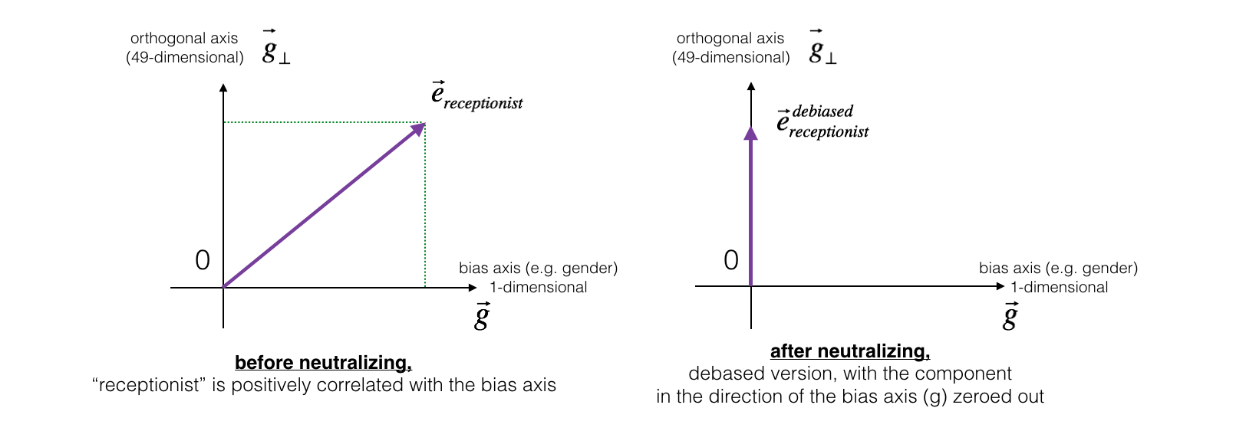

$$e^{bias\_component} = \frac{e \cdot g}{||g||_2^2} * g\tag{2}$$  

$$e^{debiased} = e - e^{bias\_component}\tag{3}$$  

现在我们要实现 **neutralize()** 函数来消除包含在词汇向量里面的性别偏差，给定一个输入：词嵌入（embedding）e，那么我们可以使用下面的公式计算$e^{disabled}$


In [22]:
def neutralize(word, g, word_to_vec_map):
    """
    Removes the bias of "word" by projecting it on the space orthogonal to the bias axis. 
    This function ensures that gender neutral words are zero in the gender subspace.
    
    Arguments:
        word -- string indicating the word to debias
        g -- numpy-array of shape (50,), corresponding to the bias axis (such as gender)
        word_to_vec_map -- dictionary mapping words to their corresponding vectors.
    
    Returns:
        e_debiased -- neutralized word vector representation of the input "word"
    """
    # Select word vector representation of "word". Use word_to_vec_map. (≈ 1 line)
    e = word_to_vec_map[word]
    # Compute e_biascomponent using the formula give above. (≈ 1 line)
    e_biascomponent = np.dot(e,g)/np.sum(g**2)*g
    
    # Neutralize e by substracting e_biascomponent from it 
    # e_debiased should be equal to its orthogonal projection. (≈ 1 line)
    e_debiased = e - e_biascomponent
    
    return e_debiased
    

In [23]:
e = "receptionist"
print("cosine similarity between " + e + " and g, before neutralizing: ", cosine_similarity(word_to_vec_map["receptionist"], g))

e_debiased = neutralize("receptionist", g, word_to_vec_map)
print("cosine similarity between " + e + " and g, after neutralizing: ", cosine_similarity(e_debiased, g))

cosine similarity between receptionist and g, before neutralizing:  0.33077941750593737
cosine similarity between receptionist and g, after neutralizing:  -2.6832242276243644e-17


#### 3.2 - 性别词的均衡算法
接下来我们来看看在关于有特定性别词组中，如何将它们进行均衡，比如“男演员”与“女演员”中，与“保姆”一词更接近的是“女演员”，我们可以消去“保姆”的性别偏差，但是这并不能保证“保姆”一词与“男演员”与“女演员”之间的距离相等，我们要学的均衡算法将解决这个问题。  

均衡算法背后的关键思想是确保一对特定的单词与49维的$g_\perp$	
距离相等，原理如下图:

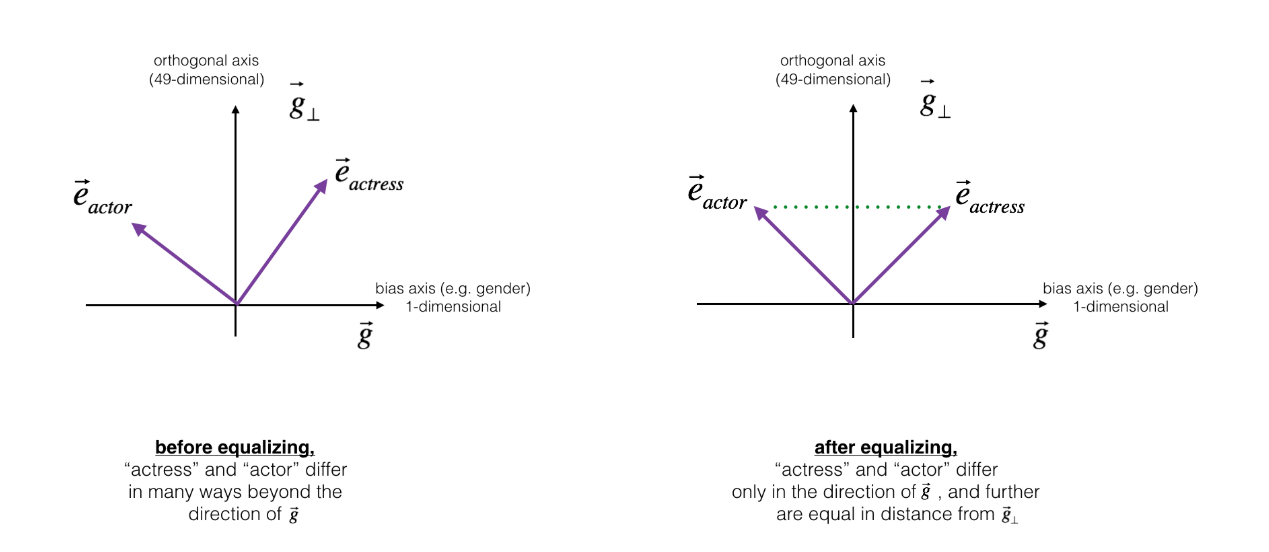

用线性代数的知识去处理可能有一些复杂，详情可见Bolukbasi et al., 2016，其主要的方程为：
$$ \mu = \frac{e_{w1} + e_{w2}}{2}\tag{4}$$  

$$ \mu_{B} = \frac {\mu \cdot \text{bias_axis}}{||\text{bias_axis}||_2^2} *\text{bias_axis}
\tag{5}$$  

$$\mu_{\perp} = \mu - \mu_{B} \tag{6}$$  

$$ e_{w1B} = \frac {e_{w1} \cdot \text{bias_axis}}{||\text{bias_axis}||_2^2} *\text{bias_axis}
\tag{7}$$   

$$ e_{w2B} = \frac {e_{w2} \cdot \text{bias_axis}}{||\text{bias_axis}||_2^2} *\text{bias_axis}
\tag{8}$$  

$$e_{w1B}^{corrected} = \sqrt{ |{1 - ||\mu_{\perp} ||^2_2} |} * \frac{e_{\text{w1B}} - \mu_B} {|(e_{w1} - \mu_{\perp}) - \mu_B)|} \tag{9}$$  

$$e_{w2B}^{corrected} = \sqrt{ |{1 - ||\mu_{\perp} ||^2_2} |} * \frac{e_{\text{w2B}} - \mu_B} {|(e_{w2} - \mu_{\perp}) - \mu_B)|} \tag{10}$$  

$$e_1 = e_{w1B}^{corrected} + \mu_{\perp} \tag{11}$$  

$$e_2 = e_{w2B}^{corrected} + \mu_{\perp} \tag{12}$$

In [33]:
def equalize(pair, bias_axis, word_to_vec_map):
    """
    Debias gender specific words by following the equalize method described in the figure above.
    
    Arguments:
    pair -- pair of strings of gender specific words to debias, e.g. ("actress", "actor") 
    bias_axis -- numpy-array of shape (50,), vector corresponding to the bias axis, e.g. gender
    word_to_vec_map -- dictionary mapping words to their corresponding vectors
    
    Returns
    e_1 -- word vector corresponding to the first word
    e_2 -- word vector corresponding to the second word
    """
    
    # Step 1: Select word vector representation of "word". Use word_to_vec_map. (≈ 2 lines)
    w1, w2 = pair
    e_w1, e_w2 = word_to_vec_map[w1], word_to_vec_map[w2]
    
    # Step 2: Compute the mean of e_w1 and e_w2 (≈ 1 line)
    mu = (e_w1 + e_w2)/2.0
    
    # Step 3: Compute the projections of mu over the bias axis and the orthogonal axis (≈ 2 lines)
    mu_B = np.dot(mu,bias_axis)/np.sum(bias_axis**2)*bias_axis
    mu_orth = mu - mu_B
    
    # Step 4: Use equations (7) and (8) to compute e_w1B and e_w2B (≈2 lines)
    e_w1B = np.divide(np.dot(e_w1,bias_axis),np.sum(bias_axis**2))*bias_axis
    e_w2B = np.divide(np.dot(e_w2,bias_axis),np.sum(bias_axis**2))*bias_axis
    
    # Step 5: Adjust the Bias part of e_w1B and e_w2B using the formulas (9) and (10) given above (≈2 lines)
    corrected_e_w1B = np.divide(np.sqrt(np.abs(1-np.sum(mu_orth**2)))*(e_w1B-mu_B),np.abs(e_w1-mu_orth-mu_B))
    corrected_e_w2B = np.divide(np.sqrt(np.abs(1-np.sum(mu_orth**2)))*(e_w2B-mu_B),np.abs(e_w2-mu_orth-mu_B))
    
    # Step 6: Debias by equalizing e1 and e2 to the sum of their corrected projections (≈2 lines)
    e1 = corrected_e_w1B + mu_orth
    e2 = corrected_e_w2B + mu_orth
    
    return e1, e2   

In [34]:
print("cosine similarities before equalizing:")
print("cosine_similarity(word_to_vec_map[\"man\"], gender) = ", cosine_similarity(word_to_vec_map["man"], g))
print("cosine_similarity(word_to_vec_map[\"woman\"], gender) = ", cosine_similarity(word_to_vec_map["woman"], g))
print()
e1, e2 = equalize(("man", "woman"), g, word_to_vec_map)
print("cosine similarities after equalizing:")
print("cosine_similarity(e1, gender) = ", cosine_similarity(e1, g))
print("cosine_similarity(e2, gender) = ", cosine_similarity(e2, g))

cosine similarities before equalizing:
cosine_similarity(word_to_vec_map["man"], gender) =  -0.11711095765336832
cosine_similarity(word_to_vec_map["woman"], gender) =  0.35666618846270376

cosine similarities after equalizing:
cosine_similarity(e1, gender) =  -0.7165727525843935
cosine_similarity(e2, gender) =  0.7396596474928908


请随意修改上面的单元格中的输入单词，以将均衡应用于其他单词对。上面的算法在大部分情况下是很有用的，但也有它的缺点，就是偏差方向是仅仅使用男女两个单词来定义的，如果使用$g_1 = e_{woman} - e_{man}$; $g_2 = e_{mother} - e_{father}$; $g_3 = e_{girl} - e_{boy}$; 然后使用g=avg(g1,g2,g3) ,应该可以更好地估计词嵌入的性别子空间维度，你可以自己去试试。


In [35]:
g1 = word_to_vec_map['woman'] - word_to_vec_map['man']
g2 = word_to_vec_map['mother'] - word_to_vec_map['father']
g3 = word_to_vec_map['girl'] - word_to_vec_map['boy']


In [43]:
g = (g1+g2+g3)/3.0
print("cosine similarities before equalizing:")
print("cosine_similarity(word_to_vec_map[\"man\"], gender) = ", cosine_similarity(word_to_vec_map["man"], g))
print("cosine_similarity(word_to_vec_map[\"woman\"], gender) = ", cosine_similarity(word_to_vec_map["woman"], g))
print()
e1, e2 = equalize(("man", "woman"), g, word_to_vec_map)
print("cosine similarities after equalizing:")
print("cosine_similarity(e1, gender) = ", cosine_similarity(e1, g))
print("cosine_similarity(e2, gender) = ", cosine_similarity(e2, g))

cosine similarities before equalizing:
cosine_similarity(word_to_vec_map["man"], gender) =  -0.0243587541234758
cosine_similarity(word_to_vec_map["woman"], gender) =  0.3979047171251496

cosine similarities after equalizing:
cosine_similarity(e1, gender) =  -0.40760482687217303
cosine_similarity(e2, gender) =  0.4055041262939141


References:

* The debiasing algorithm is from Bolukbasi et al., 2016, Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings
* The GloVe word embeddings were due to Jeffrey Pennington, Richard Socher, and Christopher D. Manning. (https://nlp.stanford.edu/projects/glove/)